# Семинар 8: Планирование и RL


## Майнор ВШЭ, 13.03.2019

## Алгоритмы Dyna-Q и MCTS

На данном семинаре мы вначале напишем класс DynaQAgent, котрый будет представлять из себя табличного Dyna-Q агента. Проведем его сравнение с Q-learning агентом, после рассмотрим другой вариант планирования: MCTS. Все варианты рассмотри на примере Taxi-v2.

После этого сравним оба варианта планирования друг с другом на примере игры в Шахматы (https://github.com/genyrosk/gym-chess).

Для начала импортируем необходимые библиотеки

In [36]:
from collections import defaultdict
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

### Dyna-Q

Создадим класс DynaQAgent, который будет решать задачу обучения методом Dyna-Q, согласно приведенному ниже алгоритму.

<img src=https://cdn-images-1.medium.com/max/1600/1*jGiNKLkGwmdjzhCUrSNJIg.png width=800>

In [37]:
# %%writefile dyna_q.py
from collections import defaultdict
import random
import math
import numpy as np

class DynaQAgent:
    def __init__(self, alpha, epsilon, discount, n_steps, get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self._memoryModel = []
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        self.n_steps = n_steps

    def get_qvalue(self, state, action):
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        self._qvalues[state][action] = value
        
    def get_model(self, state, action):
        return self._memoryModel[state][action]

    def set_model(self, state, action, value):
        self._memoryModel[state][action] = value
        
    def get_value(self, state):
        
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = max(self.get_qvalue(state, action) for action in possible_actions)

        return value

В соответствии с алгоритмом представленном выше будем добавлять методы к нашему классу. Начнем с обновления Q-значений.

In [38]:
def update(self, state, action, reward, next_state):
    alpha = self.alpha
    gamma = self.discount
    n_steps = self.n_steps
    Q_update = self.get_qvalue(state, action) + alpha*(reward + 
                gamma*self.get_value(next_state) - self.get_qvalue(state, action))
    self.set_qvalue(state, action, Q_update)
    self._memoryModel.append((state, action, reward, next_state))
    self.search()
        
DynaQAgent.update = update

Следующий шаг - этап планирования (поиска).

In [39]:
def search(self):
    n_steps = self.n_steps
    alpha = self.alpha
    gamma = self.discount
    for _ in range(n_steps):
        state, action, reward, next_state = random.choice(self._memoryModel)

        Q_update = self.get_qvalue(state, action) + alpha*(reward + 
                gamma*self.get_value(next_state) - self.get_qvalue(state, action))
        self.set_qvalue(state, action, Q_update)

DynaQAgent.search = search

В соответствии со сформированной таблицей значений - выбираем действия и используем $\epsilon$-жадную стратегию.

In [40]:
def get_best_action(self, state):
    possible_actions = self.get_legal_actions(state)

    # If there are no legal actions, return None
    if len(possible_actions) == 0:
        return None

    array_qvalues = [self.get_qvalue(state, action) for action in possible_actions]
    return possible_actions[array_qvalues.index(max(array_qvalues))]

DynaQAgent.get_best_action = get_best_action

def get_action(self, state):
    # Pick Action
    possible_actions = self.get_legal_actions(state)
    action = None

    # If there are no legal actions, return None
    if len(possible_actions) == 0:
        return None

    # agent parameters:
    epsilon = self.epsilon

    if random.random() > epsilon:
        chosen_action = self.get_best_action(state)
    else:
        chosen_action = random.choice(possible_actions)

    return chosen_action

DynaQAgent.get_action = get_action

### Сравнение с Q-learning

Сравним получившийся алгоритм с классическим Q-learning на примере Taxi-v2 enviroment.


Определим среду и агентов.

In [41]:
import gym
env = gym.make("Taxi-v2")
n_actions = env.action_space.n
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [42]:
from qlearning import QLearningAgent

a = defaultdict(lambda:0)
agent_ql = QLearningAgent(alpha=0.25, epsilon=0.05, discount=0.9,
                          get_legal_actions=lambda s: range(n_actions))

agent_dynaq = DynaQAgent(alpha=0.25, epsilon=0.05, discount=0.9, n_steps=50,
                         get_legal_actions=lambda s: range(n_actions))

Также напишем функцию play_and_train, которая будет полностью прогонять игру, тренировать агента на каждой паре состояние-действие и возвращать полученную награду.

In [43]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

DYNA-Q mean reward = 6.24
QLEARNING mean reward = 4.82


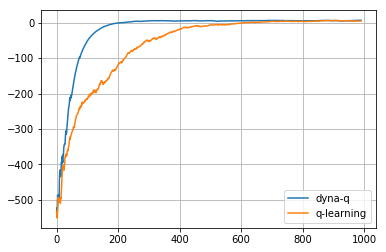

In [44]:
from IPython.display import clear_output
from pandas import DataFrame


def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_dynaq, rewards_ql = [], []

for i in range(1000):
    rewards_dynaq.append(play_and_train(env, agent_dynaq))
    rewards_ql.append(play_and_train(env, agent_ql))

    if i % 10 == 0:
        clear_output(True)
        print('DYNA-Q mean reward =', np.mean(rewards_dynaq[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.plot(moving_average(rewards_dynaq), label='dyna-q')
        plt.plot(moving_average(rewards_ql), label='q-learning')
        plt.grid()
        plt.legend()
        plt.show()

Как несложно заметить что Dyna-Q, что Q-learning сходятся к одному и тому же значению, однако в случае с Dyna-Q это происходит гораздо быстрее.

### Монте-Карло поиск по дереву - MCTS

Создадим класс UCTAgent, который реализует алгоритм UCT, общая схема которого приведена ниже:

<img src="MCTS.gif">

In [19]:
from collections import defaultdict
import random
from copy import copy
from math import sqrt, log
import numpy as np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, state, possible_actions, is_terminal):
        # Состояние
        self.state = state
        # Является ли состояние конечным
        self.is_terminal = is_terminal
        # Словарь со значениями функции Q(s, a)
        self._qvalues = defaultdict(lambda: 0)
        # Словарь с количеством выбора каждого действия в состоянии state
        self._actions_used = defaultdict(lambda: 0)
        # Количество посещений данного состояния
        self.visits = 0

In [32]:
class UCTAgent:
    def __init__(self, get_legal_actions, rollouts=5, horizon=100, gamma=0.9, ucb_const = 2, is_Chess = False):
        self.get_legal_actions = get_legal_actions
        self.rollouts = rollouts
        self.horizon = horizon
        self.ucb = ucb_const
        self.Tree = {}
        self.state_action = {}
        self.chess = {}
        self.gamma = gamma
        self.is_Chess = is_Chess
        
    def to_board(self, state):
        if self.is_Chess:
            for name, value in self.chess.items():
                if value['board'] == state['board']:
                    return name
            self.chess[len(self.chess.keys())] = state
            return len(self.chess.keys())
        else:
            return state
    
    def get_action(self, env, state):
        for _ in range(self.rollouts):
            self.simulate(copy(env), copy(state))
        return self.ucb_select(self.Tree[self.to_board(state)])
        
    def simulate(self, env, state):
        states, reward, done, env, t = self.sim_tree(env, state)
        total_reward = self.sim_default(env, states[-1], reward, done, t)
        self.back_up(states, total_reward)
        self.state_action = {}
        
    def sim_tree(self, env, init_state):    
        t = 0
        done = False
        states = []
        state = self.to_board(init_state)
        total_reward = 0
        while not done and (t < self.horizon):
            if not state in self.Tree.keys():
                if self.is_Chess:
                    self.Tree[state] = Node(self.chess[state], self.get_legal_actions(self.chess[state]), done)
                else:
                    self.Tree[state] = Node(state, self.get_legal_actions(state), done)
                states.append(state)
                return states, total_reward, done, env, t
            states.append(state)
            action = self.ucb_select(self.Tree[state])
            self.state_action[state] = action
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = self.to_board(next_state)
            t += 1
        return states, total_reward, done, env, t
            
    def sim_default(self, env, state, prev_reward, done, t):
        total_reward = prev_reward
        while not done:# and (t < self.horizon):
            action = self.default_policy(state)
            next_state, reward, done, _ = env.step(action)
            self.state_action[state] = action
            state = self.to_board(next_state)
            total_reward += reward
            t += 1
        return total_reward
        
    def default_policy(self, state):
        if self.is_Chess:
            return random.choice(self.get_legal_actions(self.chess[state]))
        else:
            return random.choice(self.get_legal_actions(state))

        
    def back_up(self, states, total_reward):
        state_action = self.state_action
        for state in states:
            self.Tree[state].visits += 1
            action = state_action[state]
            self.Tree[state]._actions_used[action] += 1
            self.Tree[state]._qvalues[action] += self.gamma*(total_reward - self.Tree[state]._qvalues[action]
                                                 ) / float(self.Tree[state]._actions_used[action])
        
    def ucb_select(self, state_node):
        c = self.ucb
        state = state_node.state
        if self.is_Chess:
            possible_actions = self.get_legal_actions(self.chess[state])
        else:
            possible_actions = self.get_legal_actions(state)
        array_qvalues = [state_node._qvalues[action] + c*sqrt(log(state_node.visits)/state_node._actions_used[action]) 
                         if action in state_node._actions_used.keys() else float('+inf') for action in possible_actions ]
        #print(possible_actions)
        return possible_actions[array_qvalues.index(max(array_qvalues))]

Также сравним UCT с предыдущими алгоритмами на все том же Taxi-v2

In [33]:
import gym
env = gym.make("Taxi-v2", )
n_actions = env.action_space.n
env.render()
agent_uct = UCTAgent(get_legal_actions=lambda s: range(n_actions))

from qlearning import QLearningAgent
# from dyna_q import DynaQAgent


a = defaultdict(lambda:0)
agent_ql = QLearningAgent(alpha=0.25, epsilon=0.05, discount=0.9,
                          get_legal_actions=lambda s: range(n_actions))

agent_dynaq = DynaQAgent(alpha=0.25, epsilon=0.05, discount=0.9, n_steps=50,
                         get_legal_actions=lambda s: range(n_actions))

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [34]:
def play_and_train_ts(env, agent, t_max=10**4):   
    total_reward = 0.0
    s = env.reset()
    for t in range(t_max):
        a = agent.get_action(copy(env), s)
        s, r, done, _ = env.step(a)
        total_reward += r
        if done:
            break
    return total_reward

In [ ]:
from IPython.display import clear_output
from pandas import DataFrame


def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_dynaq, rewards_ql, rewards_uct = [], [], []

for i in range(51):
    rewards_dynaq.append(play_and_train(env, agent_dynaq))
    rewards_ql.append(play_and_train(env, agent_ql))
    rewards_uct.append(play_and_train_ts(env, agent_uct))

    if i % 10 == 0:
        clear_output(True)
        print('DYNA-Q mean reward =', np.mean(rewards_dynaq[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        print('UCT mean reward =', np.mean(rewards_uct[-100:]))
        plt.plot(moving_average(rewards_uct), label='uct')
        plt.plot(moving_average(rewards_dynaq), label='dyna-q')
        plt.plot(moving_average(rewards_ql), label='q-learning')
        plt.grid()
        plt.legend()
        plt.show()

Видно, что благодаря планированию до конца, UCT практически сразу находит оптимальную стратегию. Также видно, что среднее значение награды для UCT выше, чем для Dyna-Q и Q-learning.